In [136]:
# imports
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import DATA_PATH, GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs as mtbs_adapter
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm
from src.utils.eval import mse, rmse, r_squared

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")

from src.counterfactuals.nearby import nearby

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)
importlib.reload(nearby)

2024-02-01 01:30:17,086 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-01 01:30:17,088 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-01 01:30:17,134 DEBUG: Logger /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.counterfactuals.nearby.nearby' from '/home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py'>

Sample command line interface: 
```
python src/counterfactuals/nearby/nearby.py -n “placebo_set_5” -t /maps/fire-regen/data/evaluation/placebo_sets/set5/placebo_aug.pkl -u /maps/fire-regen/data/evaluation/placebo_sets/set5/calibration_aug.pkl -k 100 -e mean -p /maps/fire-regen/data/counterfactuals/nearby &
```

In [137]:
INPUT_PATH = f"{DATA_PATH}/counterfactuals/nearby"

In [138]:
def evaluate_error_across_placebo_sets(outcome_variable, estimator="mean"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    rmses = []
    r2s = []
    for i in range(1, 6):
        print(f"Evaluating Placebo Set {i}:")
        df = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_{i}_100_{estimator}.pkl").dropna()
        x_cf = df[f"{outcome_variable}_cf"]
        x = df[outcome_variable]
        outcome_diff = x_cf - x

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")
        print(f"RMA regression: {rma_regression(x, x_cf)}")
        rmses.append(a)
        r2s.append(b)

        sns.kdeplot(outcome_diff, ax=ax)
        ax.axvline(x=0)
    print(f"Avg RMSE: {sum(rmses) / len(rmses)}")
    print(f"Avg R^2: {sum(r2s) / len(r2s)}")


In [139]:
def evaluate_error_across_placebo_sets_rel(outcome_variable, estimator="mean"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    rmses = []
    r2s = []
    for i in range(1, 6):
        print(f"Evaluating Placebo Set {i}:")
        df = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_{i}_100_{estimator}.pkl").dropna()
        x_cf = df[f"{outcome_variable}_cf"]
        x = df[outcome_variable]
        outcome_diff = (x_cf - x)/(x_cf + x)

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")
        print(f"RMA regression: {rma_regression(x, x_cf)}")
        rmses.append(a)
        r2s.append(b)

        sns.kdeplot(outcome_diff, ax=ax)
        ax.set_xlim((-0.5, 0.5))
        ax.axvline(x=0)
    print(f"Avg RMSE: {sum(rmses) / len(rmses)}")
    print(f"Avg R^2: {sum(r2s) / len(r2s)}")

    return fig, ax


In [140]:
def evaluate_error_across_fire_size(outcome_variable, estimator="mean"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    small_fires = load_pickle(f"{INPUT_PATH}/nearby_small_fires_100_{estimator}.pkl").dropna()
    large_fires = load_pickle(f"{INPUT_PATH}/nearby_large_fires_100_{estimator}.pkl").dropna()

    print(f"Evaluating Small Fires:")
    x_cf = small_fires[f"{outcome_variable}_cf"]
    x = small_fires[outcome_variable]
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax)
    ax.axvline(x=0)

    print(f"Evaluating Large Fires:")
    x_cf = large_fires[f"{outcome_variable}_cf"]
    x = large_fires[outcome_variable]
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax)
    ax.axvline(x=0)


### Plot scatter

In [78]:
df = load_pickle(f"{INPUT_PATH}/nearby_small_fires_100_mean.pkl").dropna()

In [104]:
import numpy as np
from scipy.stats import linregress

def rma_regression(x, y):
  """
  Calculates the Reduced Major Axis (RMA) regression line.

  Args:
    x: The independent variable.
    y: The dependent variable.

  Returns:
    A tuple of (slope, intercept).
  """

  # Calculate the ordinary least squares (OLS) regression line.
  slope, intercept, r_value, p_value, std_err = linregress(x, y)

  # Calculate the covariance between x and y.
  cov = np.cov(x, y)[0, 1]

  # Calculate the variance of x.
  var_x = np.var(x)

  # Calculate the slope of the RMA regression line.
  rma_slope = cov / var_x

  # Calculate the intercept of the RMA regression line.
  rma_intercept = intercept - rma_slope * np.mean(x)

  return rma_slope, rma_intercept

import matplotlib.pyplot as plt 
import numpy as np    

def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    sns.lineplot(x=x_vals, y=y_vals, ax=ax)

(0.0, 1.0)

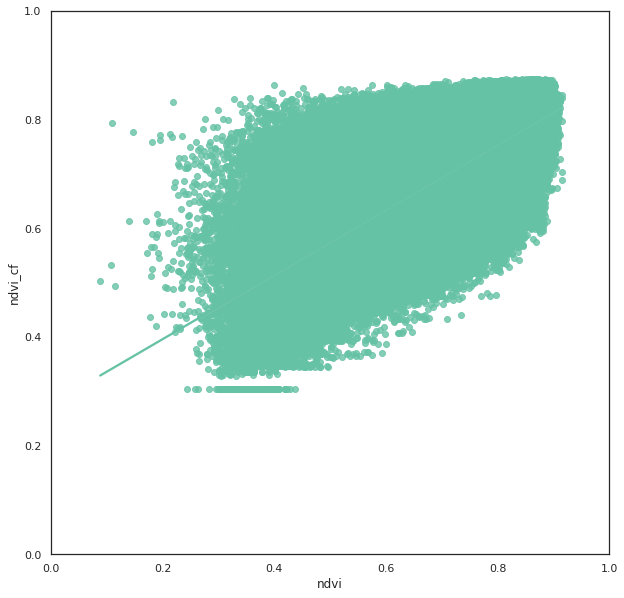

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.regplot(df, x="ndvi", y="ndvi_cf")
ax.set_xlim((0,1))
ax.set_ylim((0,1))

(0.0, 1.0)

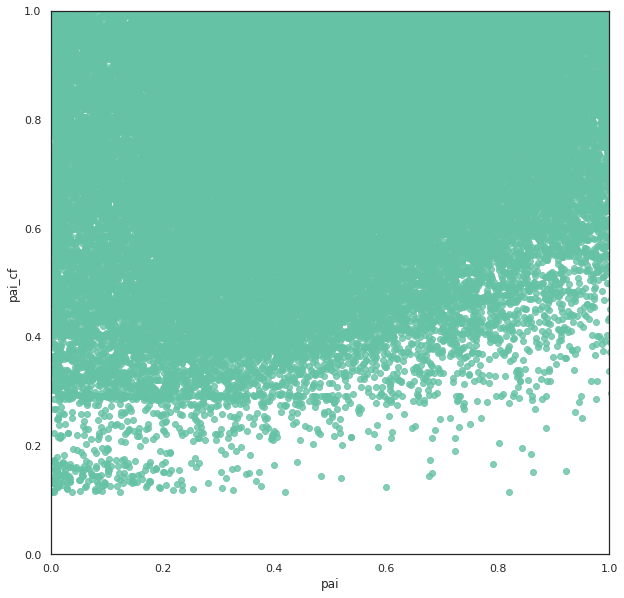

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.regplot(df, x="pai", y="pai_cf")
ax.set_xlim((0,1))
ax.set_ylim((0,1))

## Eval across Fire Sizes

Evaluating Small Fires:
RMSE: 0.08131249108135208
R^2: 0.5592084514987191
RMA regression: (0.5983120704345859, -0.13894541796384707)
Evaluating Large Fires:
RMSE: 0.09600093605967389
R^2: 0.2525638381418158
RMA regression: (0.3754568294352923, 0.15897813404050232)


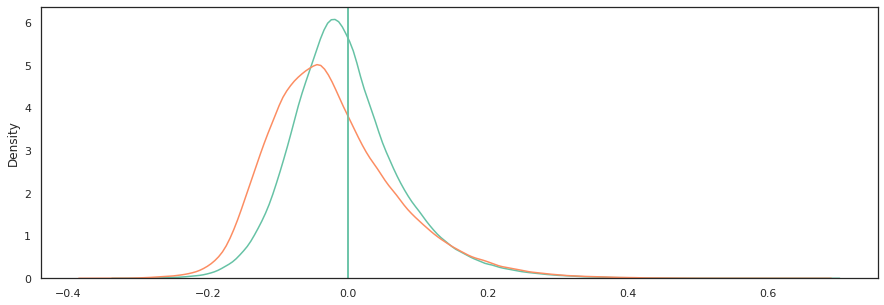

In [87]:
evaluate_error_across_fire_size("ndvi")

(0.0, 1.0)

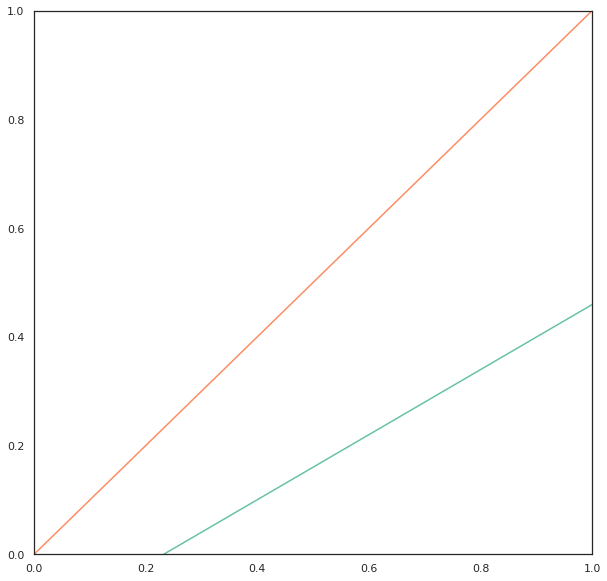

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
abline(0.5983120704345859, -0.13894541796384707, ax)
abline(1, 0, ax)
ax.set_xlim((0,1))
ax.set_ylim((0,1))

(0.0, 1.0)

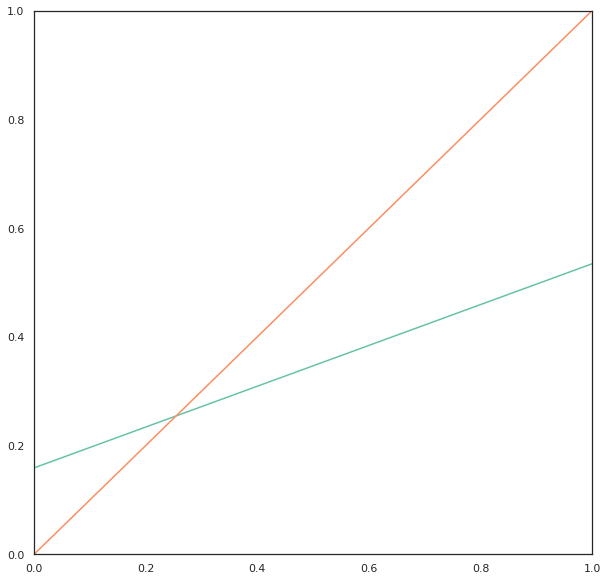

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
abline(0.3754568294352923, 0.15897813404050232, ax)
abline(1, 0, ax)
ax.set_xlim((0,1))
ax.set_ylim((0,1))

Evaluating Small Fires:
RMSE: 9.081913909008678
R^2: 0.26721645545235406
Evaluating Large Fires:
RMSE: 10.729499752734311
R^2: -0.014673675367784966


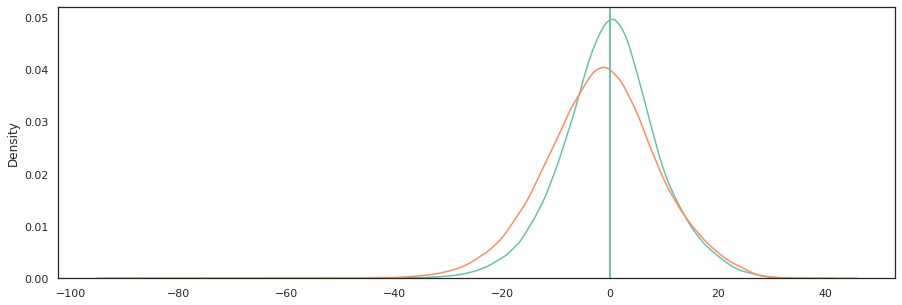

In [27]:
evaluate_error_across_fire_size("rh_98")

Evaluating Small Fires:
RMSE: 7.517968240684689
R^2: 0.2690679824575962
Evaluating Large Fires:
RMSE: 9.112732341822607
R^2: -0.003628301689584834


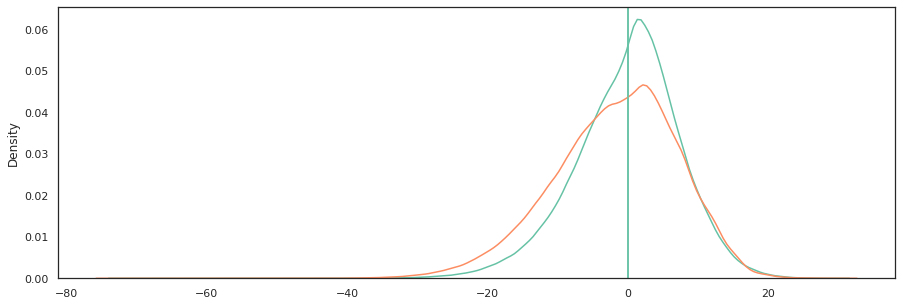

In [28]:
evaluate_error_across_fire_size("rh_70")

Evaluating Small Fires:
RMSE: 1.2975287319139224
R^2: 0.1961534434387685
Evaluating Large Fires:
RMSE: 1.4466480936394928
R^2: -0.013024935217980094


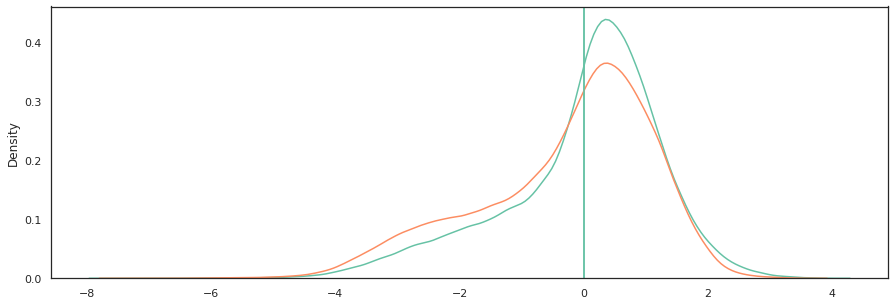

In [29]:
evaluate_error_across_fire_size("pai")

Evaluating Small Fires:
RMSE: 0.23412177338264575
R^2: 0.22450599576135155
Evaluating Large Fires:
RMSE: 0.25999158268266376
R^2: -0.008665620364455506


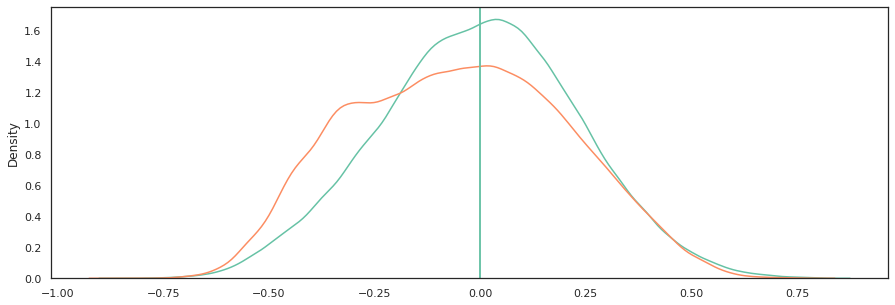

In [30]:
evaluate_error_across_fire_size("cover")

## Eval on Placebo Sets 1-5

Evaluating Placebo Set 1:
RMSE: 0.0952024451744656
R^2: 0.35415334684961997
RMA regression: (0.545812243544108, -0.07528389441977634)
Evaluating Placebo Set 2:
RMSE: 0.0936257353632757
R^2: 0.3982743647310163
RMA regression: (0.5170827249560381, -0.03450568786735747)
Evaluating Placebo Set 3:
RMSE: 0.09124208091186276
R^2: 0.4866982932337288
RMA regression: (0.5788778391377486, -0.1077663946763378)
Evaluating Placebo Set 4:
RMSE: 0.09213756449832025
R^2: 0.37023951671126887
RMA regression: (0.4623675284318189, 0.04516467165764171)
Evaluating Placebo Set 5:
RMSE: 0.08938833323577493
R^2: 0.42971145047485015
RMA regression: (0.5124955499510984, -0.02404502505368089)
Avg RMSE: 0.09231923183673986
Avg R^2: 0.40781539440009684


(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

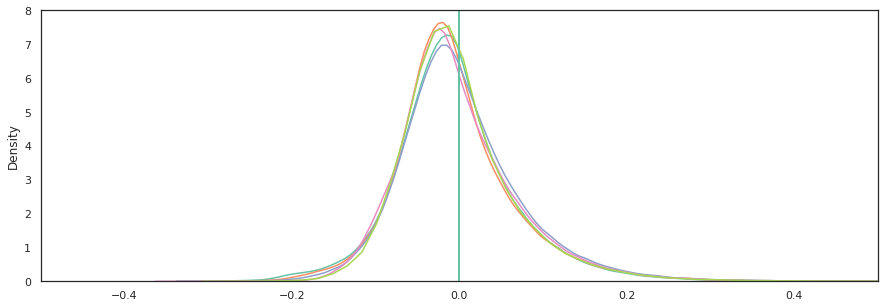

In [114]:
evaluate_error_across_placebo_sets_rel("ndvi")

Evaluating Placebo Set 1:
RMSE: 10.23910327227653
R^2: 0.11320293014588234
RMA regression: (0.2595561536075119, 11.226312844888445)
Evaluating Placebo Set 2:
RMSE: 9.688580534302098
R^2: 0.1425609355335803
RMA regression: (0.2214831262802515, 12.910423642778213)
Evaluating Placebo Set 3:
RMSE: 9.466304513084529
R^2: 0.18969366188882086
RMA regression: (0.2996188879616285, 9.13063941979803)
Evaluating Placebo Set 4:
RMSE: 9.863091897237826
R^2: 0.11289388883941076
RMA regression: (0.2227388594033265, 12.391303506265501)
Evaluating Placebo Set 5:
RMSE: 9.883365465863026
R^2: 0.14606546369643236
RMA regression: (0.2240629915990512, 12.954526491492016)
Avg RMSE: 9.828089136552801
Avg R^2: 0.14088337602082532


(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

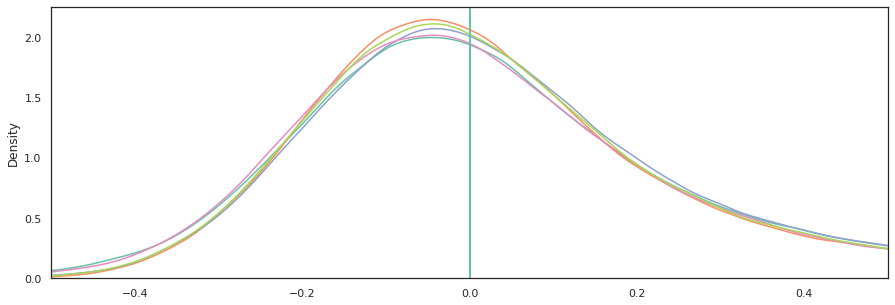

In [115]:
evaluate_error_across_placebo_sets_rel("rh_98")

Evaluating Placebo Set 1:
RMSE: 0.0952024451744656
R^2: 0.35415334684961997
Evaluating Placebo Set 2:
RMSE: 0.0936257353632757
R^2: 0.3982743647310163
Evaluating Placebo Set 3:
RMSE: 0.09124208091186276
R^2: 0.4866982932337288
Evaluating Placebo Set 4:
RMSE: 0.09213756449832025
R^2: 0.37023951671126887
Evaluating Placebo Set 5:
RMSE: 0.08938833323577493
R^2: 0.42971145047485015
Avg RMSE: 0.09231923183673986
Avg R^2: 0.40781539440009684


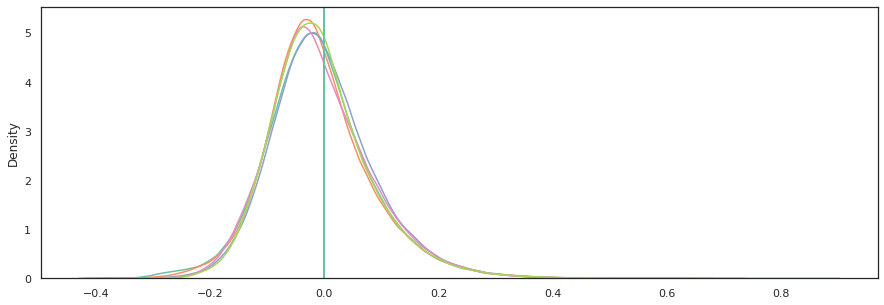

In [9]:
evaluate_error_across_placebo_sets("ndvi")

Evaluating Placebo Set 1:
RMSE: 0.09670283508446147
R^2: 0.3336358551273412
Evaluating Placebo Set 2:
RMSE: 0.09495656711299681
R^2: 0.38104647363641886
Evaluating Placebo Set 3:
RMSE: 0.09307346690561975
R^2: 0.46588579541955544
Evaluating Placebo Set 4:
RMSE: 0.09294517822954573
R^2: 0.35915104813119403
Evaluating Placebo Set 5:
RMSE: 0.09024029981050395
R^2: 0.41878872309112036
Avg RMSE: 0.09358366942862555
Avg R^2: 0.391701579081126


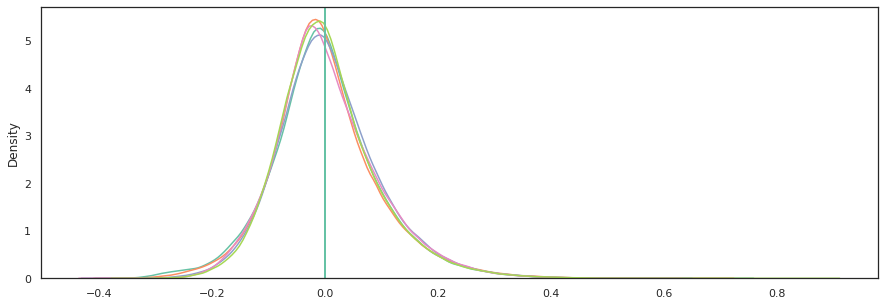

In [10]:
evaluate_error_across_placebo_sets("ndvi", "median")

### RH_98

Evaluating Placebo Set 1:
RMSE: 10.23910327227653
R^2: 0.11320293014588234
RMA regression: (0.2595561536075119, 11.226312844888445)
Evaluating Placebo Set 2:
RMSE: 9.688580534302098
R^2: 0.1425609355335803
RMA regression: (0.2214831262802515, 12.910423642778213)
Evaluating Placebo Set 3:
RMSE: 9.466304513084529
R^2: 0.18969366188882086
RMA regression: (0.2996188879616285, 9.13063941979803)
Evaluating Placebo Set 4:
RMSE: 9.863091897237826
R^2: 0.11289388883941076
RMA regression: (0.2227388594033265, 12.391303506265501)
Evaluating Placebo Set 5:
RMSE: 9.883365465863026
R^2: 0.14606546369643236
RMA regression: (0.2240629915990512, 12.954526491492016)
Avg RMSE: 9.828089136552801
Avg R^2: 0.14088337602082532


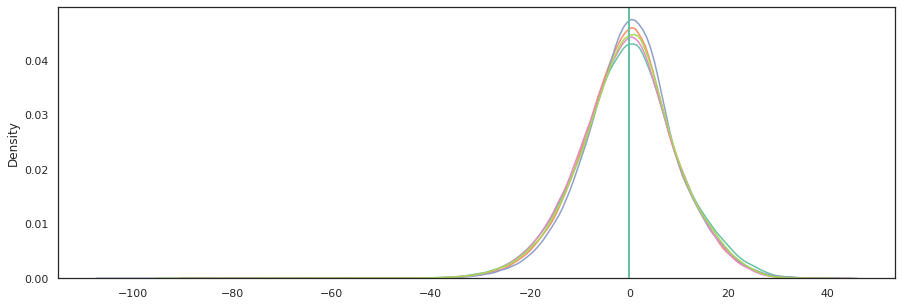

In [141]:
evaluate_error_across_placebo_sets("rh_98")

Evaluating Placebo Set 1:
RMSE: 10.46975572787567
R^2: 0.07279983311243654
Evaluating Placebo Set 2:
RMSE: 9.844837122894429
R^2: 0.11468050131674079
Evaluating Placebo Set 3:
RMSE: 9.644872866463652
R^2: 0.15883477677080904
Evaluating Placebo Set 4:
RMSE: 9.98819576120506
R^2: 0.09024698593797531
Evaluating Placebo Set 5:
RMSE: 10.013065883909098
R^2: 0.1235058617655912
Avg RMSE: 9.99214547246958
Avg R^2: 0.11201359178071058


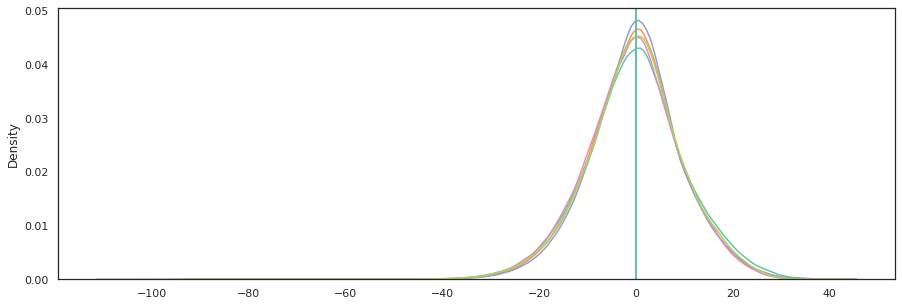

In [12]:
evaluate_error_across_placebo_sets("rh_98", "median")

### RH_70

Evaluating Placebo Set 1:
RMSE: 8.492980190643165
R^2: 0.10250030426861945
RMA regression: (0.24607131532189164, 6.181568284939367)
Evaluating Placebo Set 2:
RMSE: 8.012017550504915
R^2: 0.15307565529883116
RMA regression: (0.2381091649269261, 6.185308216557885)
Evaluating Placebo Set 3:
RMSE: 7.650212584758064
R^2: 0.17896418308565298
RMA regression: (0.27616785740967514, 5.0236136130736355)
Evaluating Placebo Set 4:
RMSE: 8.107246281942594
R^2: 0.13125851062042448
RMA regression: (0.2194022134639279, 6.328399182158539)
Evaluating Placebo Set 5:
RMSE: 8.21409102407576
R^2: 0.13938357027185133
RMA regression: (0.21942454714118334, 6.716869722040759)
Avg RMSE: 8.0953095263849
Avg R^2: 0.1410364447090759


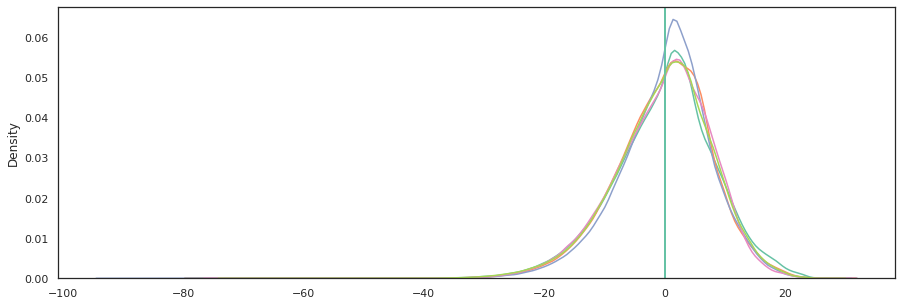

In [142]:
evaluate_error_across_placebo_sets("rh_70")

Evaluating Placebo Set 1:
RMSE: 8.7810539794631
R^2: 0.04058306176260407
Evaluating Placebo Set 2:
RMSE: 8.242443181101887
R^2: 0.10366004275063057
Evaluating Placebo Set 3:
RMSE: 7.864893361926314
R^2: 0.1322377101276404
Evaluating Placebo Set 4:
RMSE: 8.328473608079724
R^2: 0.08319988662988553
Evaluating Placebo Set 5:
RMSE: 8.413943861676142
R^2: 0.09699567463305936
Avg RMSE: 8.326161598449435
Avg R^2: 0.09133527518076398


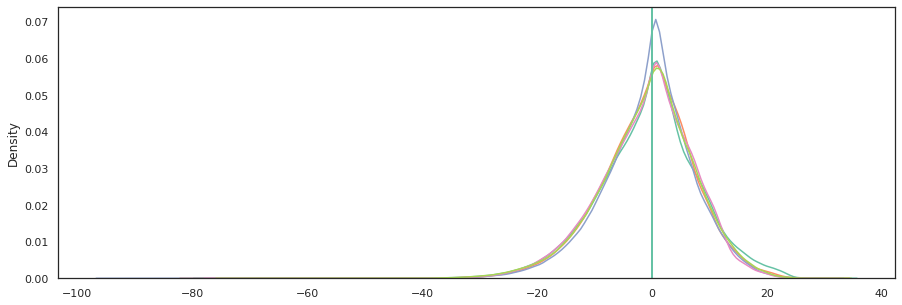

In [14]:
evaluate_error_across_placebo_sets("rh_70", "median")

Evaluating Placebo Set 1:
RMSE: 6.9023050995734305
R^2: 0.0978053728815027
RMA regression: (0.22315670235024201, 3.83328559236233)
Evaluating Placebo Set 2:
RMSE: 6.554739312306068
R^2: 0.16077226643919984
RMA regression: (0.24654652342933656, 3.4273409191289046)
Evaluating Placebo Set 3:
RMSE: 6.067560094927203
R^2: 0.17498895979457285
RMA regression: (0.25948001268171045, 2.982671024176126)
Evaluating Placebo Set 4:
RMSE: 6.534112271744371
R^2: 0.15361723190590093
RMA regression: (0.22969260749140433, 3.469361411514586)
Evaluating Placebo Set 5:
RMSE: 6.738956372887375
R^2: 0.1353080214121457
RMA regression: (0.2134123093539237, 3.982966222976824)
Avg RMSE: 6.559534630287689
Avg R^2: 0.14449837048666442


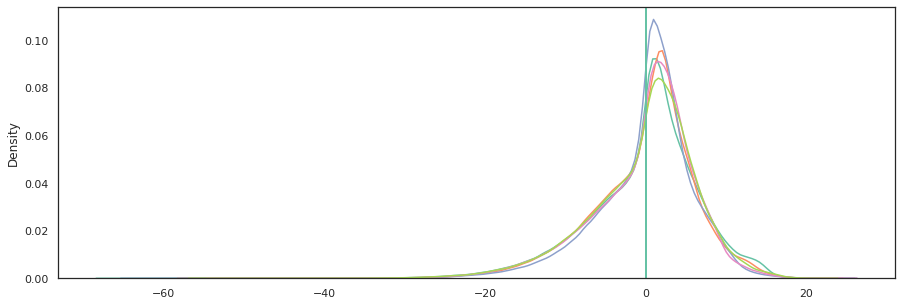

In [143]:
evaluate_error_across_placebo_sets("rh_50")

### PAI

Evaluating Placebo Set 1:
RMSE: 1.3899965047184542
R^2: 0.08177737232484583
RMA regression: (0.15158848332938954, 1.1665482154456872)
Evaluating Placebo Set 2:
RMSE: 1.3602092183595347
R^2: 0.10838961579007966
RMA regression: (0.17392073791231152, 1.1453224981247856)
Evaluating Placebo Set 3:
RMSE: 1.329988222522198
R^2: 0.11494395426290027
RMA regression: (0.17855339572038634, 1.0512732677329462)
Evaluating Placebo Set 4:
RMSE: 1.3632040244647137
R^2: 0.11110088865303425
RMA regression: (0.1850594615022199, 1.1074837667436594)
Evaluating Placebo Set 5:
RMSE: 1.3768179085733685
R^2: 0.10165475621386333
RMA regression: (0.1560670667550878, 1.2251709539979798)
Avg RMSE: 1.3640431757276539
Avg R^2: 0.10357331744894467


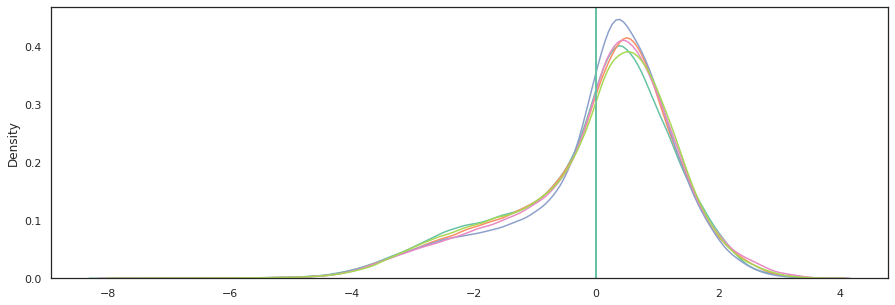

In [144]:
evaluate_error_across_placebo_sets("pai")

Evaluating Placebo Set 1:
RMSE: 1.4499401840612287
R^2: 0.0008728814499306958
Evaluating Placebo Set 2:
RMSE: 1.4187928552826963
R^2: 0.029933122901683817
Evaluating Placebo Set 3:
RMSE: 1.384165390155066
R^2: 0.04136969422218506
Evaluating Placebo Set 4:
RMSE: 1.4229778022664068
R^2: 0.03143894234971978
Evaluating Placebo Set 5:
RMSE: 1.4337153065232993
R^2: 0.02587182700052637
Avg RMSE: 1.4219183076577395
Avg R^2: 0.025897293584809144


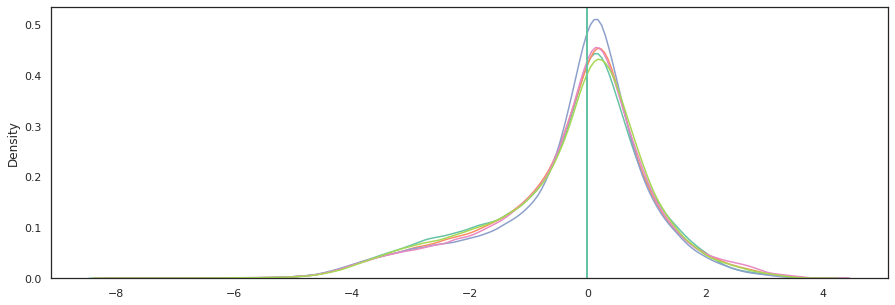

In [16]:
evaluate_error_across_placebo_sets("pai", "median")

### Cover

Evaluating Placebo Set 1:
RMSE: 0.2526593989032223
R^2: 0.10759720260016403
RMA regression: (0.19084910618049736, 0.2949711653811411)
Evaluating Placebo Set 2:
RMSE: 0.24671022000481382
R^2: 0.11678895879603235
RMA regression: (0.19205719561302417, 0.30262214124367437)
Evaluating Placebo Set 3:
RMSE: 0.245213292062311
R^2: 0.14672180394772927
RMA regression: (0.22048772343496542, 0.25951036592503196)
Evaluating Placebo Set 4:
RMSE: 0.2501636302683325
R^2: 0.11996191054283312
RMA regression: (0.2052916973259014, 0.2869191989660389)
Evaluating Placebo Set 5:
RMSE: 0.24799737009644018
R^2: 0.11970383169230592
RMA regression: (0.18358795142970444, 0.3159110854875759)
Avg RMSE: 0.24854878226702395
Avg R^2: 0.12215474151581293


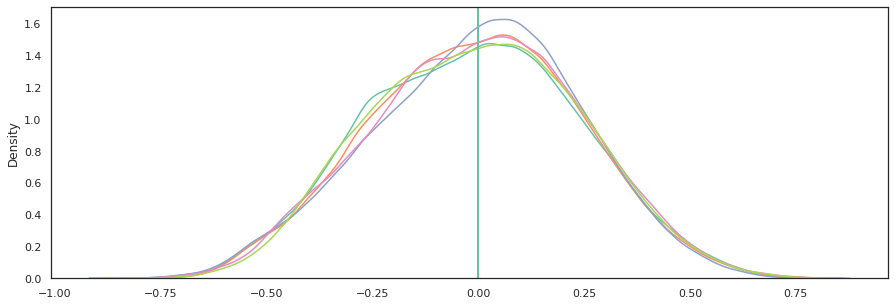

In [145]:
evaluate_error_across_placebo_sets("cover")

Evaluating Placebo Set 1:
RMSE: 0.26121341234675055
R^2: 0.04614809583708279
Evaluating Placebo Set 2:
RMSE: 0.2563942443412167
R^2: 0.04609142702413549
Evaluating Placebo Set 3:
RMSE: 0.2547761826333833
R^2: 0.07887136203462852
Evaluating Placebo Set 4:
RMSE: 0.26269713985537574
R^2: 0.029570886596347767
Evaluating Placebo Set 5:
RMSE: 0.2557406197826597
R^2: 0.06387447427859705
Avg RMSE: 0.2581643197918772
Avg R^2: 0.052911249154158325


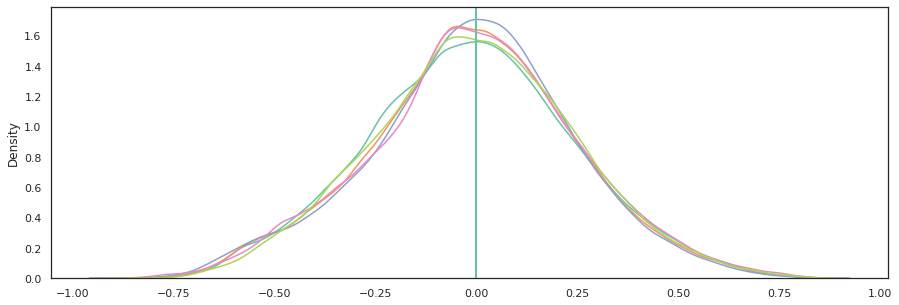

In [18]:
evaluate_error_across_placebo_sets("cover", "median")

In [68]:
df.ndvi.dropna()

shot_number
165411100300289117    0.448430
42640800300290331     0.617775
42640800300290332     0.581237
42640800300290333     0.670504
193740200200084898    0.502145
                        ...   
97400500300181863     0.536403
97400500300181868     0.739911
97400600300613068     0.664788
97400600300613079     0.825601
97400600300613080     0.818217
Name: ndvi, Length: 430998, dtype: float64

In [55]:
mean_eval = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_1_100_mean.pkl")
median_eval = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_1_100_median.pkl")

In [56]:
mean_eval["ndvi_diff"] = mean_eval.ndvi_cf - mean_eval.ndvi
median_eval["ndvi_diff"] = median_eval.ndvi_cf - median_eval.ndvi

<AxesSubplot: xlabel='ndvi_diff', ylabel='Density'>

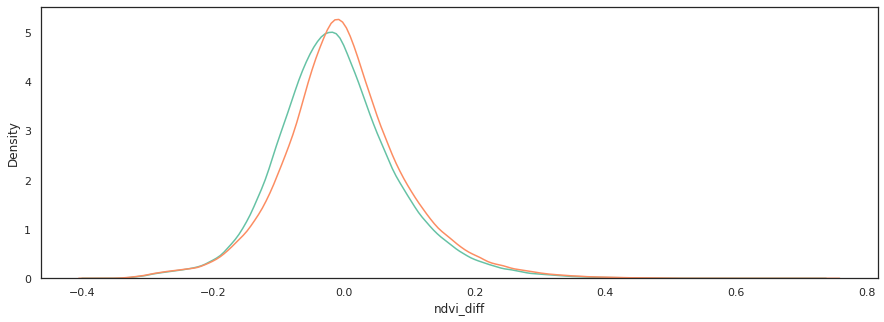

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(mean_eval, x="ndvi_diff")
sns.kdeplot(median_eval, x="ndvi_diff")

## Evaluate nearby on Placebo Set1

In [50]:
outcome_vars = ["ndvi", "rh_98", "rh_70", "pai"]

In [51]:
placebo_set = load_pickle(f"{PLACEBO_PATH}/set1/placebo.pkl")
callibration_set = load_pickle(f"{PLACEBO_PATH}/set1/callibration.pkl")

In [52]:
nc = nearby.NearbyGenerator(outcome_vars, 100)

In [53]:
placebo_cf = nc.generate(
    placebo_set.join(unburned[outcome_vars], how="left"),
    callibration_set.join(unburned[outcome_vars], how="left"))

2024-01-29 19:48:09,467 INFO: Calling nearest neighbour to find 100 nn. [in generate at /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py:25]
2024-01-29 19:51:33,444 INFO: Calculating counterfactual for ndvi [in generate at /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py:32]
2024-01-29 19:58:22,159 INFO: Calculating counterfactual for rh_98 [in generate at /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py:32]
2024-01-29 20:06:30,018 INFO: Calculating counterfactual for rh_70 [in generate at /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py:32]
2024-01-29 20:14:26,345 INFO: Calculating counterfactual for pai [in generate at /home/jk871/fire-regen/src/counterfactuals/nearby/nearby.py:32]


In [44]:
x

,geometry,rh_98,rh_98_cf
shot_number,,,
165411100300289117,POINT (-119.56438 37.37769),6.02,23.92753
42640800300290331,POINT (-119.56192 37.36201),15.13,23.92753
42640800300290332,POINT (-119.56143 37.36168),8.98,23.92753
42640800300290333,POINT (-119.56094 37.36134),9.47,23.92753
193740200200084898,POINT (-119.56162 37.36825),10.04,23.92753
...,...,...,...
226850100200079251,POINT (-119.95507 37.45068),13.85,23.92753
236310500200079104,POINT (-119.95521 37.44997),18.01,23.92753
188290800300305900,POINT (-119.96420 37.44251),18.74,23.92753


### Inference on burned and unburned

In [31]:
burned = load_pickle(f"{INPUT_PATH}/inference/nearby_burned_unburned_100_mean.pkl")

In [38]:
from src.data.adapters import mtbs
burned = mtbs.get_burn_severity(burned)

In [47]:
def evaluate_error_on_burned_areas(outcome_variable, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    for severity in [0, 1, 2]:
        print(f"Evaluating Severity {severity}")
        df_t = df[df.severity == severity]
        x_cf = df_t[f"{outcome_variable}_cf"]
        x = df_t[outcome_variable]
        outcome_diff = x_cf - x

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")

        sns.kdeplot(outcome_diff, ax=ax)
        ax.axvline(x=0)

    print("\n")
    print(f"Evaluating Placebo Test Set 2")
    df_t = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_3_100_mean.pkl").dropna()
    x_cf = df_t[f"{outcome_variable}_cf"]
    x = df_t[outcome_variable]
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")

    sns.kdeplot(outcome_diff, ax=ax, color="black")
    ax.axvline(x=0)


In [116]:
def evaluate_error_on_burned_areas_rel(outcome_variable, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    for severity in [0, 1, 2]:
        print(f"Evaluating Severity {severity}")
        df_t = df[df.severity == severity]
        x_cf = df_t[f"{outcome_variable}_cf"]
        x = df_t[outcome_variable]
        outcome_diff = (x_cf - x)/(x_cf + x)

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")
        print(f"RMA regression: {rma_regression(x, x_cf)}")

        sns.kdeplot(outcome_diff, ax=ax)
        ax.axvline(x=0)

    print("\n")
    print(f"Evaluating Placebo Test Set 2")
    df_t = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_3_100_mean.pkl").dropna()
    x_cf = df_t[f"{outcome_variable}_cf"]
    x = df_t[outcome_variable]
    outcome_diff = (x_cf - x)/(x_cf + x)

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax, color="black")
    ax.axvline(x=0)

    return fig, ax


Evaluating Severity 0
RMSE: 0.11147580338627086
R^2: 0.4270637964116347
Evaluating Severity 1
RMSE: 0.1561174136095006
R^2: -0.12789702219283572
Evaluating Severity 2
RMSE: 0.2270736240672755
R^2: -0.5449947513369764


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288


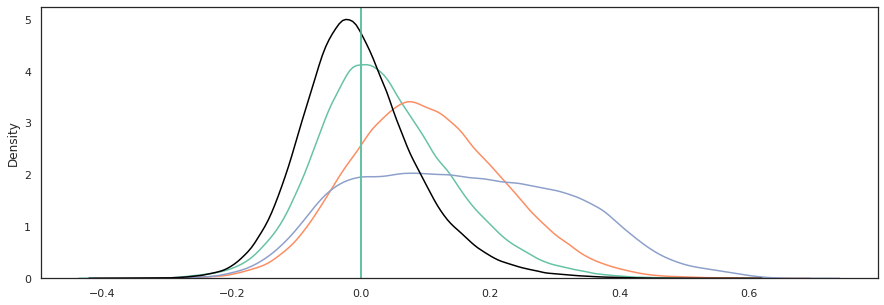

In [48]:
evaluate_error_on_burned_areas("ndvi", burned)

Evaluating Severity 0
RMSE: 0.11147580338627086
R^2: 0.4270637964116347
RMA regression: (0.4821960854976787, 0.05733684558490082)
Evaluating Severity 1
RMSE: 0.1561174136095006
R^2: -0.12789702219283572
RMA regression: (0.4003273058125981, 0.20531600379503023)
Evaluating Severity 2
RMSE: 0.2270736240672755
R^2: -0.5449947513369764
RMA regression: (0.22482657034964107, 0.43160729096462946)


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288
RMA regression: (0.5788778391377486, -0.1077663946763378)


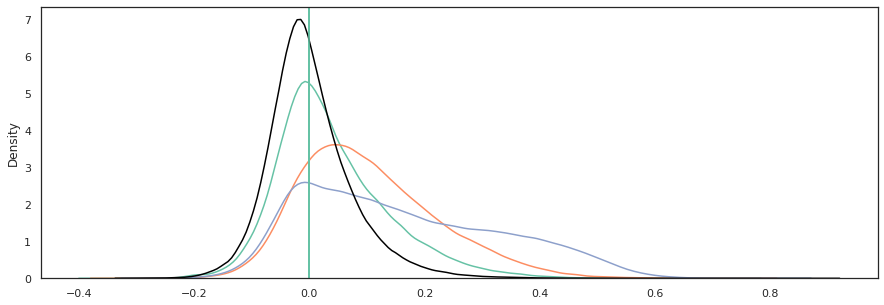

In [117]:
fix, ax = evaluate_error_on_burned_areas_rel("ndvi", burned)

Evaluating Severity 0
RMSE: 10.514553158702377
R^2: 0.24308314020652821
RMA regression: (0.2790668759505329, 9.755541648003112)
Evaluating Severity 1
RMSE: 10.878528341074096
R^2: 0.11673260794940388
RMA regression: (0.25823125722391255, 12.140249654064625)
Evaluating Severity 2
RMSE: 14.165093636391395
R^2: -1.3299187217635864
RMA regression: (0.1418424629579601, 19.097438410578974)


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086
RMA regression: (0.2996188879616285, 9.13063941979803)


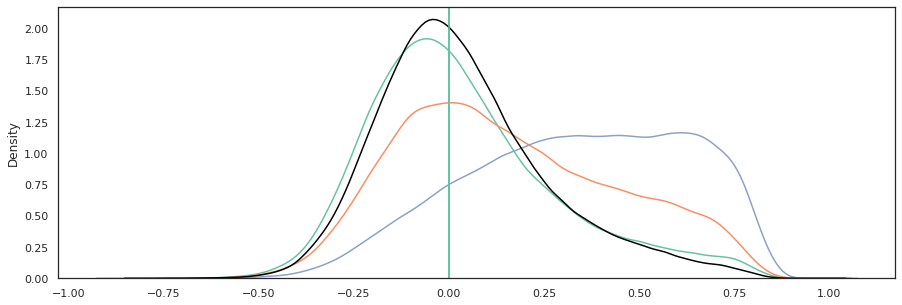

In [118]:
fix, ax = evaluate_error_on_burned_areas_rel("rh_98", burned)

Evaluating Severity 0
RMSE: 10.514553158702377
R^2: 0.24308314020652821
Evaluating Severity 1
RMSE: 10.878528341074096
R^2: 0.11673260794940388
Evaluating Severity 2
RMSE: 14.165093636391395
R^2: -1.3299187217635864


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


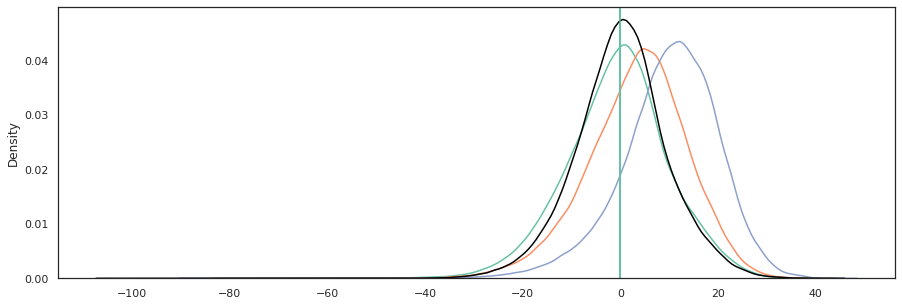

In [51]:
evaluate_error_on_burned_areas("rh_98", burned)

Evaluating Severity 0
RMSE: 10.514553158702377
R^2: 0.24308314020652821
Evaluating Severity 1
RMSE: 10.878528341074096
R^2: 0.11673260794940388
Evaluating Severity 2
RMSE: 14.165093636391395
R^2: -1.3299187217635864


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


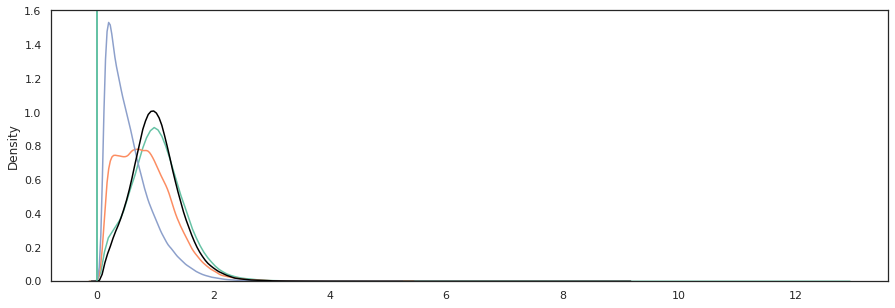

In [52]:
evaluate_error_on_burned_areas_rel("rh_98", burned)

Evaluating Severity 0
RMSE: 1.3403846704287359
R^2: 0.1347633692701804
Evaluating Severity 1
RMSE: 1.357623665270337
R^2: 0.042731684092342404
Evaluating Severity 2
RMSE: 1.4851982378727484
R^2: -0.25795070939370923


Evaluating Placebo Test Set 2
RMSE: 1.329988222522198
R^2: 0.11494395426290027


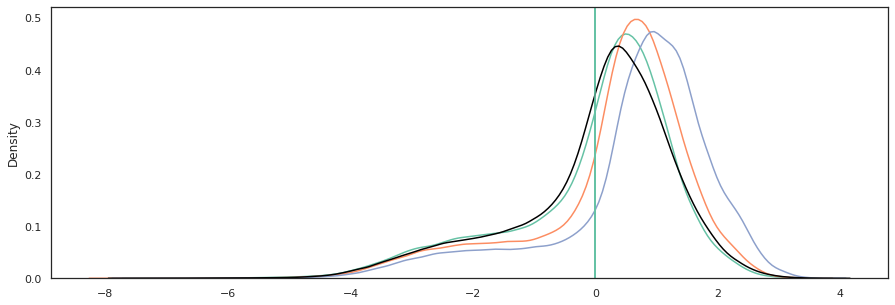

In [53]:
evaluate_error_on_burned_areas("pai", burned)

Evaluating Severity 0
RMSE: 1.3403846704287359
R^2: 0.1347633692701804
Evaluating Severity 1
RMSE: 1.357623665270337
R^2: 0.042731684092342404
Evaluating Severity 2
RMSE: 1.4851982378727484
R^2: -0.25795070939370923


Evaluating Placebo Test Set 2
RMSE: 1.329988222522198
R^2: 0.11494395426290027


(0.0, 7.0)

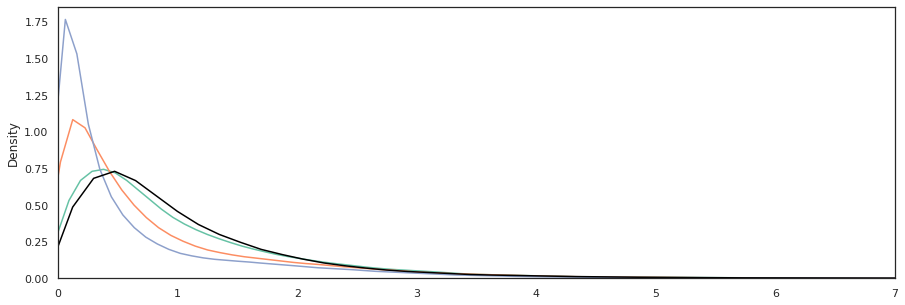

In [56]:
fig, ax = evaluate_error_on_burned_areas_rel("pai", burned)
ax.set_xlim((0, 7))

### Eval depending on YSF

In [59]:
def evaluate_error_on_burned_areas_ysf(outcome_variable, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    for ysf in range(5, 40, 5):
        print(f"Evaluating YSF {ysf}")
        df_t = df[df.YSF_cat_5 == ysf]
        x_cf = df_t[f"{outcome_variable}_cf"]
        x = df_t[outcome_variable]
        outcome_diff = x_cf - x

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")

        sns.kdeplot(outcome_diff, ax=ax)
        ax.axvline(x=0)

    print("\n")
    print(f"Evaluating Placebo Test Set 2")
    df_t = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_3_100_mean.pkl").dropna()
    x_cf = df_t[f"{outcome_variable}_cf"]
    x = df_t[outcome_variable]
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")

    sns.kdeplot(outcome_diff, ax=ax, color="black")
    ax.axvline(x=0)


In [125]:
def evaluate_error_on_burned_areas_ysf_rel(outcome_variable, df, df_placebo):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    for ysf in range(5, 40, 5):
        print(f"Evaluating YSF {ysf}")
        df_t = df[df.YSF_cat_5 == ysf]
        x_cf = df_t[f"{outcome_variable}_cf"]
        x = df_t[outcome_variable]
        outcome_diff = (x_cf - x)/(x_cf + x)

        # Print stats
        a = rmse(x, x_cf)
        b = r_squared(x, x_cf)
        print(f"RMSE: {a}")
        print(f"R^2: {b}")
        print(f"RMA regression: {rma_regression(x, x_cf)}")

        sns.kdeplot(outcome_diff, ax=ax)
        ax.axvline(x=0)

    print("\n")
    print(f"Evaluating Placebo Test Set 2")
    df_t = df_placebo
    x_cf = df_t[f"{outcome_variable}_cf"]
    x = df_t[outcome_variable]
    outcome_diff = (x_cf - x)/(x_cf + x)

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")
    

    sns.kdeplot(outcome_diff, ax=ax, color="black")
    ax.axvline(x=0)

    return fig, ax


In [126]:
placebo_set_1 = load_pickle(f"{INPUT_PATH}/nearby_placebo_set_3_100_mean.pkl").dropna()

Evaluating YSF 5
RMSE: 0.11934190180116332
R^2: 0.25445167150041625
Evaluating YSF 10
RMSE: 0.10524482409008407
R^2: 0.4650318882814247
Evaluating YSF 15
RMSE: 0.0975313930460178
R^2: 0.5795636165488074
Evaluating YSF 20
RMSE: 0.09093115048409148
R^2: 0.607077184823108
Evaluating YSF 25
RMSE: 0.12707058551925415
R^2: 0.38917292408889614
Evaluating YSF 30
RMSE: 0.12312358566011229
R^2: 0.37824809267388015
Evaluating YSF 35
RMSE: 0.1011732223466419
R^2: 0.46002642389348025


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288


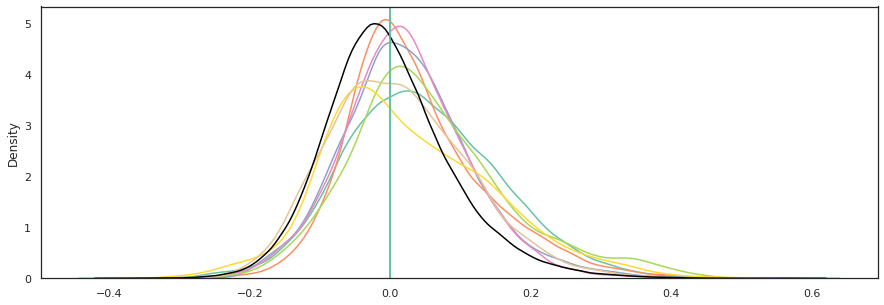

In [120]:
evaluate_error_on_burned_areas_ysf("ndvi", burned[burned.severity == 0])

Evaluating YSF 5
RMSE: 0.11934190180116332
R^2: 0.25445167150041625
RMA regression: (0.36641739376005394, 0.1967081846740029)
Evaluating YSF 10
RMSE: 0.10524482409008407
R^2: 0.4650318882814247
RMA regression: (0.50709597532035, 0.026476823552779527)
Evaluating YSF 15
RMSE: 0.0975313930460178
R^2: 0.5795636165488074
RMA regression: (0.5631777913642245, -0.05371849421054653)
Evaluating YSF 20
RMSE: 0.09093115048409148
R^2: 0.607077184823108
RMA regression: (0.6207739549785537, -0.11287078245554871)
Evaluating YSF 25
RMSE: 0.12707058551925415
R^2: 0.38917292408889614
RMA regression: (0.585806559578345, -0.03988033209569658)
Evaluating YSF 30
RMSE: 0.12312358566011229
R^2: 0.37824809267388015
RMA regression: (0.42170215026203156, 0.12474545311000096)
Evaluating YSF 35
RMSE: 0.1011732223466419
R^2: 0.46002642389348025
RMA regression: (0.4381013035161034, 0.08738847360505098)


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288
RMA regression: (0.578877839137748

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

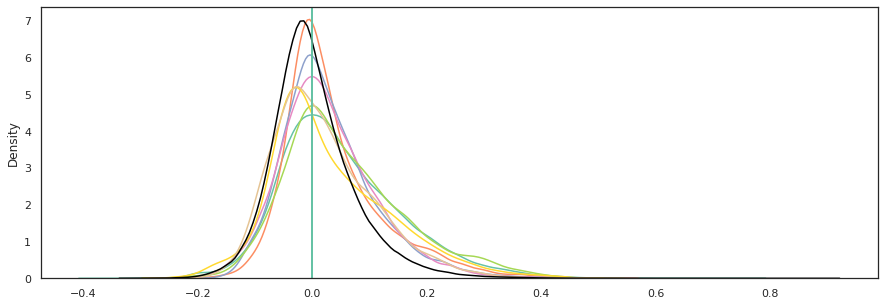

In [121]:
evaluate_error_on_burned_areas_ysf_rel("ndvi", burned[burned.severity == 0])

Evaluating YSF 5
RMSE: 0.2890209086633795
R^2: -3.5347405393629723
RMA regression: (0.17893447600608492, 0.5018685340848714)
Evaluating YSF 10
RMSE: 0.20000951825189311
R^2: -1.334404643063257
RMA regression: (0.2099153251079476, 0.4592299280405767)
Evaluating YSF 15
RMSE: 0.1462727808572477
R^2: -0.04841419637569211
RMA regression: (0.3724545472503891, 0.22754250344387636)
Evaluating YSF 20
RMSE: 0.10674741651804058
R^2: 0.4851814065175021
RMA regression: (0.6368850671095864, -0.1313617252651793)
Evaluating YSF 25
RMSE: 0.1402300947349598
R^2: 0.24554712022628622
RMA regression: (0.4893278936566607, 0.06755949626868896)
Evaluating YSF 30
RMSE: 0.09866907396078421
R^2: 0.3944227348682461
RMA regression: (0.4356852234410771, 0.0815987124837157)
Evaluating YSF 35
RMSE: 0.09286718434717216
R^2: 0.4980255043742602
RMA regression: (0.5251029197583847, -0.044149917043523224)


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288
RMA regression: (0.5788778391377486,

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

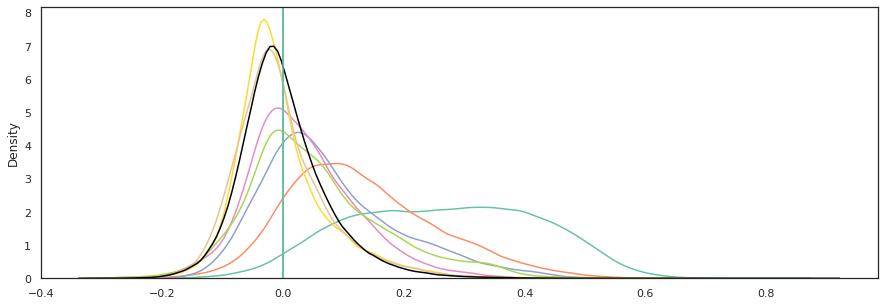

In [122]:
evaluate_error_on_burned_areas_ysf_rel("ndvi", burned[burned.severity == 2])

Evaluating YSF 5
RMSE: 14.518214739576049
R^2: -1.0150283037551295
RMA regression: (0.09470505690292966, 20.673307489986726)
Evaluating YSF 10
RMSE: 16.326469482532993
R^2: -2.0091034562362524
RMA regression: (0.16369479122661473, 20.42231458637668)
Evaluating YSF 15
RMSE: 14.250225318851275
R^2: -1.355862871174025
RMA regression: (0.13178272395224855, 18.9461664104648)
Evaluating YSF 20
RMSE: 13.54541230651362
R^2: -1.816998967584425
RMA regression: (0.2342095745029665, 16.186228074699347)
Evaluating YSF 25
RMSE: 13.46467885067808
R^2: -1.7230701606515892
RMA regression: (0.3987639476685658, 12.529199420026917)
Evaluating YSF 30
RMSE: 11.031210457265477
R^2: -2.469407022748882
RMA regression: (0.3127604576691254, 13.374482597396653)
Evaluating YSF 35
RMSE: 10.301009752249172
R^2: -1.2450963058131355
RMA regression: (0.3386703269928976, 11.109198447943328)


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086
RMA regression: (0.2996188879616285, 9.13063941979

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

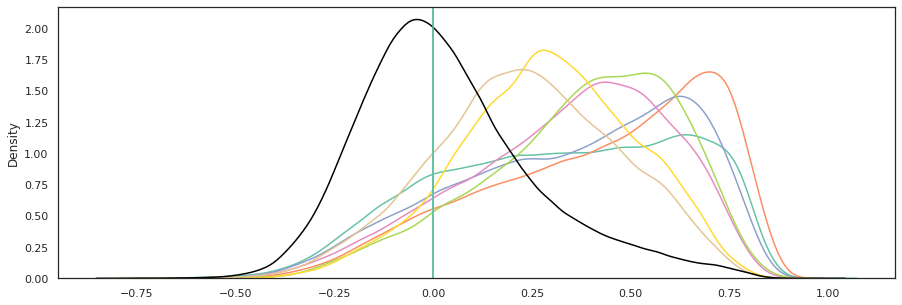

In [129]:
evaluate_error_on_burned_areas_ysf_rel("rh_98", burned[burned.severity == 2], placebo_set_1)

Evaluating YSF 5
RMSE: 0.33464815290024585
R^2: -0.4132719695233562
RMA regression: (0.07334884971832624, 0.41732645417937186)
Evaluating YSF 10
RMSE: 0.3722373937384389
R^2: -0.6876734922717711
RMA regression: (0.09883088815647921, 0.4352687707623168)
Evaluating YSF 15
RMSE: 0.3498876043527734
R^2: -0.44571213379010377
RMA regression: (0.09280419529522757, 0.4112711144254525)
Evaluating YSF 20
RMSE: 0.324557241013093
R^2: -0.2708172419239878
RMA regression: (0.15368706176525226, 0.35964097468306166)
Evaluating YSF 25
RMSE: 0.3174316149020922
R^2: -0.20600791723417378
RMA regression: (0.22537779746990125, 0.32396290795657223)
Evaluating YSF 30
RMSE: 0.27799464401301405
R^2: -0.04780686409614465
RMA regression: (0.13489315366684063, 0.34908910864347387)
Evaluating YSF 35
RMSE: 0.2806900871930424
R^2: 0.03673848818880876
RMA regression: (0.19414230980277364, 0.3025880901224335)


Evaluating Placebo Test Set 2
RMSE: 0.245213292062311
R^2: 0.14672180394772927
RMA regression: (0.22048772343

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

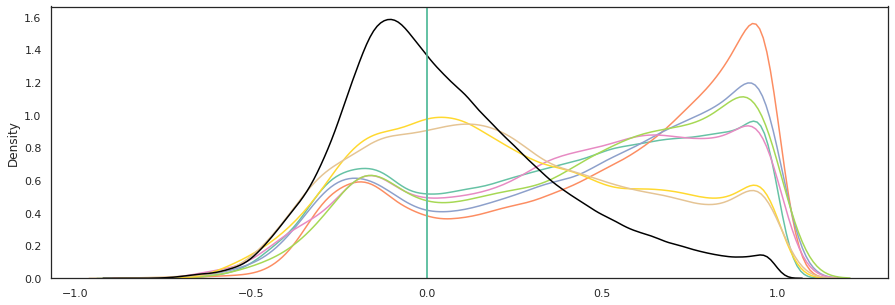

In [127]:
evaluate_error_on_burned_areas_ysf_rel("cover", burned[burned.severity == 2], placebo_set_1)

Evaluating YSF 5
RMSE: 0.3473364630595518
R^2: -0.45319927334263044
RMA regression: (0.031897547807212503, 0.47559739951314006)
Evaluating YSF 10
RMSE: 0.3838856064930914
R^2: -0.6878965250964286
RMA regression: (0.05590886275154528, 0.48429924698107335)
Evaluating YSF 15
RMSE: 0.36788726979324843
R^2: -0.4580954283148333
RMA regression: (0.029013379764285554, 0.49654966868869405)
Evaluating YSF 20
RMSE: 0.35396658865681574
R^2: -0.36482085201045544
RMA regression: (0.06853219852542614, 0.4842550047674184)
Evaluating YSF 25
RMSE: 0.35305160123068857
R^2: -0.25613370619879006
RMA regression: (0.0659284365479958, 0.5149463856949605)
Evaluating YSF 30
RMSE: 0.2748751251711873
R^2: -0.1594940902075248
RMA regression: (0.029603398407635168, 0.4555702517178804)
Evaluating YSF 35
RMSE: 0.2898636189701002
R^2: -0.13397675055520342
RMA regression: (0.06825840602196025, 0.4759556329858363)


Evaluating Placebo Test Set 2
RMSE: 0.2430388289314836
R^2: 0.005544332583569123
RMA regression: (0.14593

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot: ylabel='Density'>)

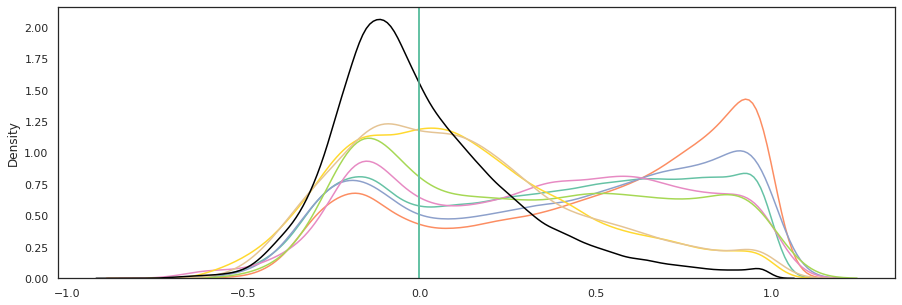

In [128]:
evaluate_error_on_burned_areas_ysf_rel("cover", burned[(burned.severity == 2) & (burned.pre_fire_ndvi > 0.67)], placebo_set_1[placebo_set_1.ndvi > 0.67])

Evaluating YSF 5
RMSE: 10.380087040378315
R^2: 0.18393378251545434
Evaluating YSF 10
RMSE: 11.559155335731212
R^2: 0.2060895619207075
Evaluating YSF 15
RMSE: 11.150998527403292
R^2: 0.24707837976824643
Evaluating YSF 20
RMSE: 9.546435464326148
R^2: 0.25131896794354236
Evaluating YSF 25
RMSE: 9.150595671693186
R^2: 0.3498232650362023
Evaluating YSF 30
RMSE: 9.739056106984664
R^2: 0.13282034011160426
Evaluating YSF 35
RMSE: 9.689730139544448
R^2: 0.17131932114076087


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


(0.0, 3.0)

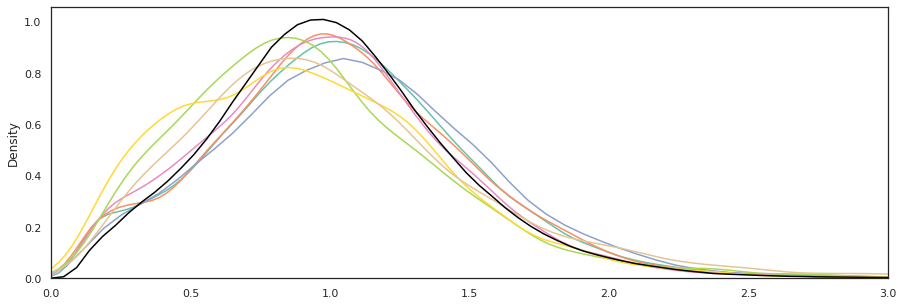

In [76]:
fig, ax = evaluate_error_on_burned_areas_ysf_rel("rh_98", burned[burned.severity == 0])
ax.set_xlim((0, 3))

Evaluating YSF 5
RMSE: 10.380087040378315
R^2: 0.18393378251545434
Evaluating YSF 10
RMSE: 11.559155335731212
R^2: 0.2060895619207075
Evaluating YSF 15
RMSE: 11.150998527403292
R^2: 0.24707837976824643
Evaluating YSF 20
RMSE: 9.546435464326148
R^2: 0.25131896794354236
Evaluating YSF 25
RMSE: 9.150595671693186
R^2: 0.3498232650362023
Evaluating YSF 30
RMSE: 9.739056106984664
R^2: 0.13282034011160426
Evaluating YSF 35
RMSE: 9.689730139544448
R^2: 0.17131932114076087


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


TypeError: cannot unpack non-iterable NoneType object

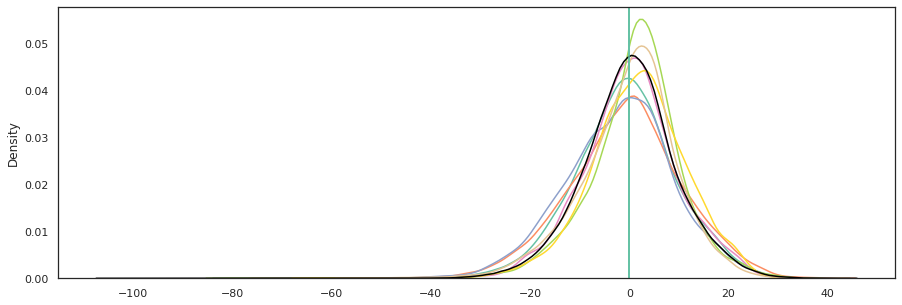

In [77]:
evaluate_error_on_burned_areas_ysf("rh_98", burned[burned.severity == 0])

In [61]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

Evaluating YSF 5
RMSE: 0.18308949359313806
R^2: -1.046223327093172
Evaluating YSF 10
RMSE: 0.15330644500102494
R^2: -0.2318683164190365
Evaluating YSF 15
RMSE: 0.11789208334373555
R^2: 0.3958322924667036
Evaluating YSF 20
RMSE: 0.1061767121897673
R^2: 0.5087610484323752
Evaluating YSF 25
RMSE: 0.1365336500111166
R^2: 0.33730196512536226
Evaluating YSF 30
RMSE: 0.1216891157651699
R^2: 0.3149470434384386
Evaluating YSF 35
RMSE: 0.10090219720252137
R^2: 0.5015650559575733


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288


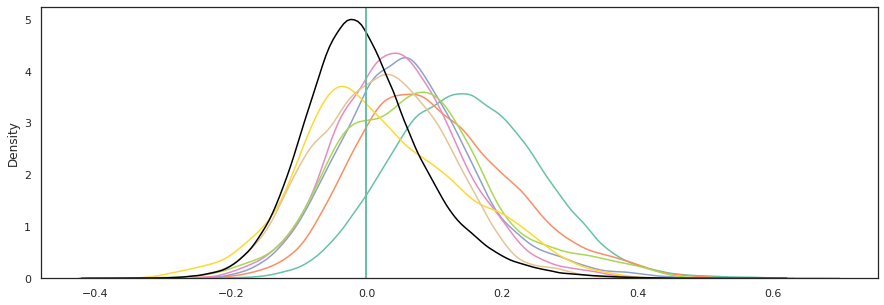

In [62]:
evaluate_error_on_burned_areas_ysf("ndvi", burned[burned.severity == 1])

Evaluating YSF 5
RMSE: 0.2890209086633795
R^2: -3.5347405393629723
Evaluating YSF 10
RMSE: 0.20000951825189311
R^2: -1.334404643063257
Evaluating YSF 15
RMSE: 0.1462727808572477
R^2: -0.04841419637569211
Evaluating YSF 20
RMSE: 0.10674741651804058
R^2: 0.4851814065175021
Evaluating YSF 25
RMSE: 0.1402300947349598
R^2: 0.24554712022628622
Evaluating YSF 30
RMSE: 0.09866907396078421
R^2: 0.3944227348682461
Evaluating YSF 35
RMSE: 0.09286718434717216
R^2: 0.4980255043742602


Evaluating Placebo Test Set 2
RMSE: 0.09124208091186276
R^2: 0.4866982932337288


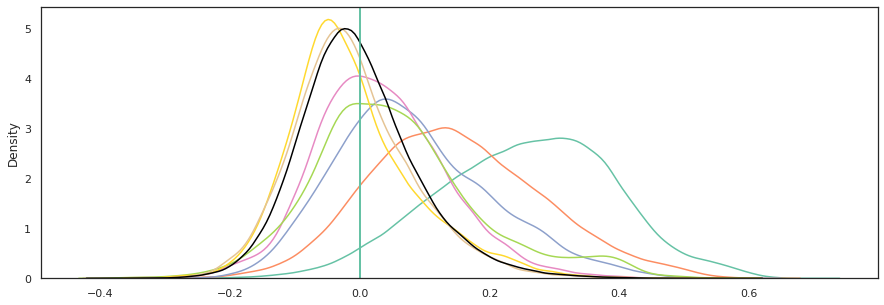

In [63]:
evaluate_error_on_burned_areas_ysf("ndvi", burned[burned.severity == 2])

Evaluating YSF 5
RMSE: 14.518214739576049
R^2: -1.0150283037551295
Evaluating YSF 10
RMSE: 16.326469482532993
R^2: -2.0091034562362524
Evaluating YSF 15
RMSE: 14.250225318851275
R^2: -1.355862871174025
Evaluating YSF 20
RMSE: 13.54541230651362
R^2: -1.816998967584425
Evaluating YSF 25
RMSE: 13.46467885067808
R^2: -1.7230701606515892
Evaluating YSF 30
RMSE: 11.031210457265477
R^2: -2.469407022748882
Evaluating YSF 35
RMSE: 10.301009752249172
R^2: -1.2450963058131355


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


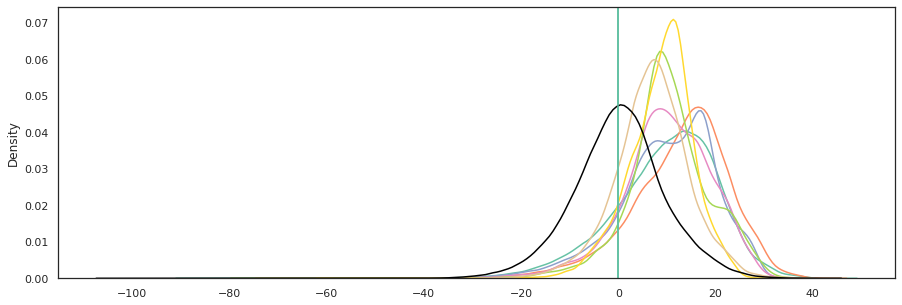

In [64]:
evaluate_error_on_burned_areas_ysf("rh_98", burned[burned.severity == 2])

Evaluating YSF 5
RMSE: 14.518214739576049
R^2: -1.0150283037551295
Evaluating YSF 10
RMSE: 16.326469482532993
R^2: -2.0091034562362524
Evaluating YSF 15
RMSE: 14.250225318851275
R^2: -1.355862871174025
Evaluating YSF 20
RMSE: 13.54541230651362
R^2: -1.816998967584425
Evaluating YSF 25
RMSE: 13.46467885067808
R^2: -1.7230701606515892
Evaluating YSF 30
RMSE: 11.031210457265477
R^2: -2.469407022748882
Evaluating YSF 35
RMSE: 10.301009752249172
R^2: -1.2450963058131355


Evaluating Placebo Test Set 2
RMSE: 9.466304513084529
R^2: 0.18969366188882086


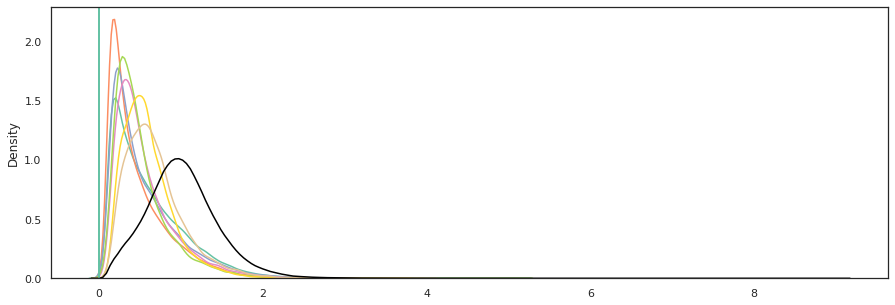

In [72]:
evaluate_error_on_burned_areas_ysf_rel("rh_98", burned[burned.severity == 2])

Evaluating YSF 5
RMSE: 1.4901729164603452
R^2: -0.3251371718155822
Evaluating YSF 10
RMSE: 1.5824338014031
R^2: -0.4141782635480191
Evaluating YSF 15
RMSE: 1.5381635264221325
R^2: -0.2690195118269314
Evaluating YSF 20
RMSE: 1.4834285604937272
R^2: -0.1511072476722326
Evaluating YSF 25
RMSE: 1.4190979474810144
R^2: -0.10043261439777851
Evaluating YSF 30
RMSE: 1.3362968514319251
R^2: -0.059714461971526855
Evaluating YSF 35
RMSE: 1.3921811045788826
R^2: -0.005322451785771731


Evaluating Placebo Test Set 2
RMSE: 1.329988222522198
R^2: 0.11494395426290027


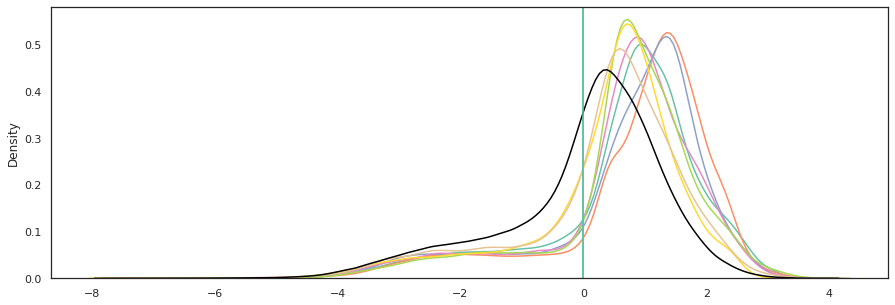

In [65]:
evaluate_error_on_burned_areas_ysf("pai", burned[burned.severity == 2])

Evaluating YSF 5
RMSE: 1.5771379393052007
R^2: -0.37677195785006545
Evaluating YSF 10
RMSE: 1.6514642859273103
R^2: -0.41720619280395477
Evaluating YSF 15
RMSE: 1.659270721700445
R^2: -0.2907425121326115
Evaluating YSF 20
RMSE: 1.686854476960912
R^2: -0.23229053103476693
Evaluating YSF 25
RMSE: 1.727266434909124
R^2: -0.1926629527006556
Evaluating YSF 30
RMSE: 1.4167510044861276
R^2: -0.12154196268446027
Evaluating YSF 35
RMSE: 1.5629335912533537
R^2: -0.1626867568656276


Evaluating Placebo Test Set 2
RMSE: 1.329988222522198
R^2: 0.11494395426290027


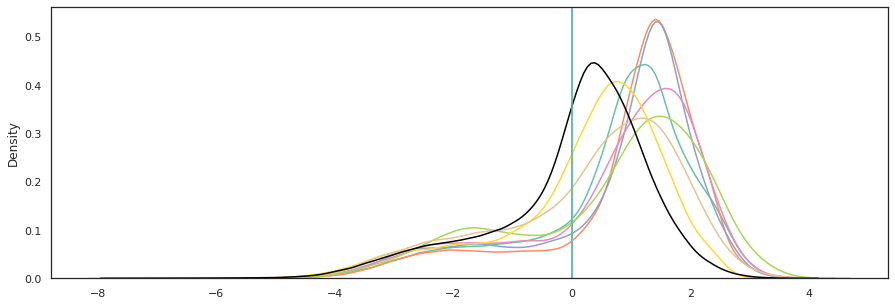

In [66]:
evaluate_error_on_burned_areas_ysf("pai", burned[(burned.severity == 2) & (burned.pre_fire_ndvi > 0.67)])

Evaluating YSF 5
RMSE: 1.3071217434119973
R^2: -0.28623263543370037
Evaluating YSF 10
RMSE: 1.3478954227476465
R^2: -0.5654198665617725
Evaluating YSF 15
RMSE: 1.345226965088058
R^2: -0.3579173870934007
Evaluating YSF 20
RMSE: 1.2798422416257382
R^2: -0.17462758537051548
Evaluating YSF 25
RMSE: 1.2169830290533294
R^2: -0.28122308478767954
Evaluating YSF 30
RMSE: 1.224519377051369
R^2: -0.19981237949082997
Evaluating YSF 35
RMSE: 1.2908750096739885
R^2: -0.02241893561524888


Evaluating Placebo Test Set 2
RMSE: 1.329988222522198
R^2: 0.11494395426290027


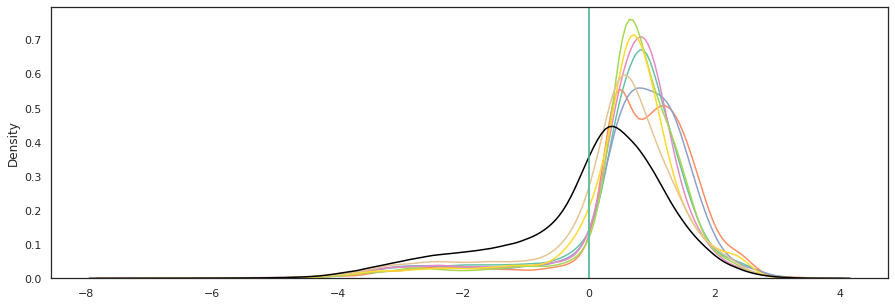

In [67]:
evaluate_error_on_burned_areas_ysf("pai", burned[(burned.severity == 2) & (burned.pre_fire_ndvi < 0.67)])